## Installing and importing the necessary Libraries


In [ ]:
## Installing sentence transformers
!pip install sentence-transformers==2.7.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 7.1 MB/s eta 0:00:00


In [ ]:
## Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report, roc_curve, roc_auc_score, auc, make_scorer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer, models
from sklearn.metrics import accuracy_score, f1_score
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import GridSearchCV
import random
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

## Converting 'Roberta-Large' to Sentence Transformer by performing pooling on the token embeddings


In [ ]:
## using pretrained microsoft/mpnet-base model
transformer_model = models.Transformer('FacebookAI/roberta-large')
## using mean pool function over the token embeddings to get fixed dimension embeddings
pooling_model = models.Pooling(transformer_model.get_word_embedding_dimension(),pooling_mode_mean_tokens=True)
## Creating the sentence transformer model
model_base = SentenceTransformer(modules=[transformer_model, pooling_model])


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Reading in the data

In [ ]:
# mount google drive
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Reading in the Airlines Twitter data in
df = pd.read_csv('/content/drive/MyDrive/Tweets.csv' )

## Classifying the reviews as numeric labels

In [ ]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
#Classifying the positive reviews as class 2 , neutral reviews as class 1 and negative reviews as class 0 under column "sentiment"
df['sentiment'] = df['airline_sentiment'].apply(lambda rating : 2 if rating =="positive" else (1 if rating=="neutral" else 0))
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,sentiment
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),1
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),2
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),1
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),0


In [ ]:
## Renaming "text" as "Text"
df1=df.rename(columns={"text": "Text"})
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  Text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

## Data Distribution

In [ ]:
df1.sentiment.value_counts(ascending=True)

,count
sentiment,
2,2363
1,3099
0,9178


<Axes: ylabel='Type'>

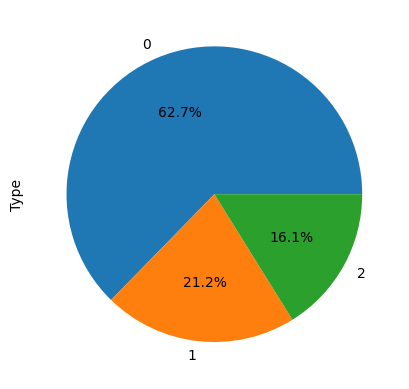

In [ ]:
df1.groupby('sentiment').size().plot(kind='pie',
                                       y = "sentiment",
                                       label = "Type",
                                       autopct='%1.1f%%')

## Preparing the data for encoding

In [ ]:
# Splitting into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(df1['Text'],
                                                    df1['sentiment'],
                                                    test_size=0.2,
                                                    random_state=21,
                                                    stratify=df1['sentiment'])



In [ ]:
## Converting to list for downstream processing
X_train_list=X_train.tolist()
X_test_list=X_test.tolist()

## Encoding the texts using the Base Sentence Transformer Model and running Classification Algorithms

In [ ]:
# Encoding the X_train using base sentence transformer model
vect_train = model_base.encode(X_train_list, show_progress_bar = True)
vect_test = model_base.encode(X_test_list, show_progress_bar = True)

Batches:   0%|          | 0/366 [00:00<?, ?it/s]

Batches:   0%|          | 0/92 [00:00<?, ?it/s]

In [ ]:
# Running LGBoost algorithm for classification
# Defining values for the hyperparameters to search through
param_grid = {
'max_bin': [255, 765],
'num_iterations': [100, 150],
'num_leaves': [20, 31]
}
best_hyperparameters = {}
best_values = {}
# define the model
model_lgbm = LGBMClassifier(objective='multiclass', random_state=5)
# Initializing GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=model_lgbm, param_grid=param_grid,
                           scoring='accuracy', cv=5)
# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(vect_train, y_train)
# Getting the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())
print(best_hyperparameters)
print(best_values)
# Training the model with the best hyperparameters
best_model = LGBMClassifier(objective='multiclass',**best_params, random_state=5)
best_model.fit(vect_train, y_train)
# evaluate the model
y_pred = best_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 9369, number of used features: 1024
[LightGBM] [Info] Start training from score -0.466871
[LightGBM] [Info] Start training from score -1.552796
[LightGBM] [Info] Start training from score -1.823973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 9369, number of used features: 1024
[LightGBM] [Info] Start training from score -0.466871
[LightGBM] [Info] Start training from score -1.552796
[LightGBM] [Info] Start training from score -1.823973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.0413

In [ ]:
# Running XGBoost algorithm for classification
# Defining values for the hyperparameters to search through
param_grid = {
 'max_depth':range(4,10,2),
 'min_child_weight':range(1,6,2)
}
best_hyperparameters = {}
best_values = {}
# define the model
model_xgb = XGBClassifier(objective='multiclass', random_state=5)
# Initializing GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid,
                           scoring='accuracy', cv=5)
# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(vect_train, y_train)
# Getting the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())
print(best_hyperparameters)
print(best_values)
# Training the model with the best hyperparameters
best_model = XGBClassifier(objective='multiclass',**best_params, random_state=5)
best_model.fit(vect_train, y_train)
# evaluate the model
y_pred = best_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

['max_depth', 'min_child_weight']
[6, 5]
Confusion Matrix - 
 [[1725   87   23]
 [ 191  387   42]
 [  54   65  354]]
Classification report - 
               precision    recall  f1-score   support

           0     0.8756    0.9401    0.9067      1835
           1     0.7180    0.6242    0.6678       620
           2     0.8449    0.7484    0.7937       473

    accuracy                         0.8422      2928
   macro avg     0.8128    0.7709    0.7894      2928
weighted avg     0.8373    0.8422    0.8379      2928



## Encoding the texts using the Base Sentence Transformer Model finetuned on CosineSimilarityLoss and running Classification Algorithms

In [ ]:
## Creating a function for transforming our dataset for finetuning the Sentence Transformers model on CosineSimilarityLoss
def input_example_generation(X_train, y_train, triplets, num_itr):
  train = pd.concat([X_train, y_train], axis=1)
  train_pos = train.loc[train["sentiment"] == 2]
  train_neg = train.loc[train["sentiment"] == 0]
  train_neu = train.loc[train["sentiment"] == 1]
  train_pos_text_list = train_pos["Text"].tolist()
  train_neg_text_list = train_neg["Text"].tolist()
  train_neu_text_list = train_neu["Text"].tolist()
  for x in range((num_itr)):
    for y in range(len(train_pos_text_list)):
      count = x*len(train_pos_text_list) + y
      # Setting the seed value to get the same set of random texts everytime
      random.seed(count)
      torch.manual_seed(count)
      # For each positive sentiment text, randomly selecting another positive text sentence and appending to triplet with target similarity score as 1.0
      currentSentence = train_pos_text_list[y]
      posSentence = random.choice(train_pos_text_list)
      triplets.append(InputExample(texts=[currentSentence, posSentence], label=1.0))
      # For each positive sentiment text, randomly selecting a negative sentiment text and appending to triplet with target similarity score as 0
      negSentence = random.choice(train_neg_text_list)
      triplets.append(InputExample(texts=[currentSentence, negSentence], label=0.0))
      # For each positive sentiment text, randomly selecting a neutral sentiment text and appending to triplet with target similarity score as 0.5
      neuSentence = random.choice(train_neu_text_list)
      triplets.append(InputExample(texts=[currentSentence, neuSentence], label=0.5))
  return (triplets)

In [ ]:
## Creating the Input Examples
train_examples = []
num_itr = 5
train_examples = input_example_generation((X_train), (y_train), train_examples,num_itr)
# Defining DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
# Specifying number of epochs and warmup steps
num_epochs = 1
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)

In [ ]:
# Defining Trainloss with loss as CosineSimilarityLoss
model = model_base
train_loss = losses.CosineSimilarityLoss(model)

In [ ]:
# Finetuning the model based on CosineSimilarityLoss
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1772 [00:00<?, ?it/s]

In [ ]:
# Finetuning the model based on CosineSimilarityLoss
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1772 [00:00<?, ?it/s]

In [ ]:
import time
start_time = time.time()

In [ ]:
# Encoding the X_train using base sentence transformer model
vect_train = model.encode(X_train_list, show_progress_bar = True)
vect_test = model.encode(X_test_list, show_progress_bar = True)

Batches:   0%|          | 0/366 [00:00<?, ?it/s]

Batches:   0%|          | 0/92 [00:00<?, ?it/s]

In [ ]:
# Running XGBoost algorithm for classification
# Defining values for the hyperparameters to search through
param_grid = {
 'max_depth':range(4,10,2),
 'min_child_weight':range(1,6,2)
}
best_hyperparameters = {}
best_values = {}
# define the model
model_xgb = XGBClassifier(objective='multiclass', random_state=5)
# Initializing GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid,
                           scoring='accuracy', cv=5)
# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(vect_train, y_train)
# Getting the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())
print(best_hyperparameters)
print(best_values)
# Training the model with the best hyperparameters
best_model = XGBClassifier(objective='multiclass',**best_params, random_state=5)
best_model.fit(vect_train, y_train)
# evaluate the model
y_pred = best_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

['max_depth', 'min_child_weight']
[6, 5]
Confusion Matrix - 
 [[1712   95   28]
 [ 101  479   40]
 [  24   52  397]]
Classification report - 
               precision    recall  f1-score   support

           0     0.9320    0.9330    0.9325      1835
           1     0.7652    0.7726    0.7689       620
           2     0.8538    0.8393    0.8465       473

    accuracy                         0.8839      2928
   macro avg     0.8503    0.8483    0.8493      2928
weighted avg     0.8840    0.8839    0.8839      2928



In [ ]:
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 806.7819123268127 seconds


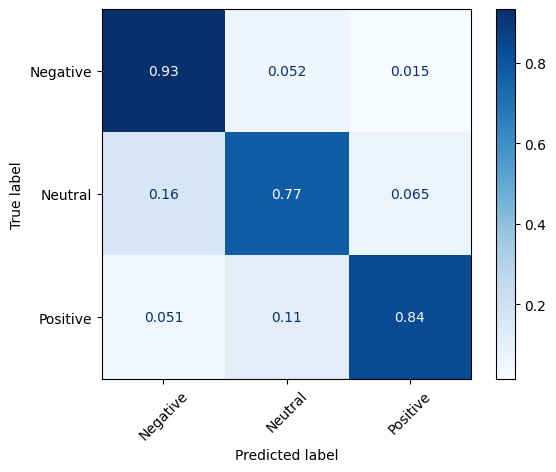

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(best_model, vect_test, y_test,normalize='true',cmap = 'Blues', xticks_rotation=45, display_labels=["Negative", "Neutral", "Positive"])

In [ ]:
# Running LGBoost algorithm for classification
# Defining values for the hyperparameters to search through
param_grid = {
'max_bin': [255, 765],
'num_iterations': [100, 150],
'num_leaves': [20, 31]
}
best_hyperparameters = {}
best_values = {}
# define the model
model_lgbm = LGBMClassifier(objective='multiclass', random_state=5)
# Initializing GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=model_lgbm, param_grid=param_grid,
                           scoring='accuracy', cv=5)
# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(vect_train, y_train)
# Getting the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())
print(best_hyperparameters)
print(best_values)
# Training the model with the best hyperparameters
best_model = LGBMClassifier(objective='multiclass',**best_params, random_state=5)
best_model.fit(vect_train, y_train)
# evaluate the model
y_pred = best_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 9369, number of used features: 1024
[LightGBM] [Info] Start training from score -0.466871
[LightGBM] [Info] Start training from score -1.552796
[LightGBM] [Info] Start training from score -1.823973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 9369, number of used features: 1024
[LightGBM] [Info] Start training from score -0.466871
[LightGBM] [Info] Start training from score -1.552796
[LightGBM] [Info] Start training from score -1.823973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.0459

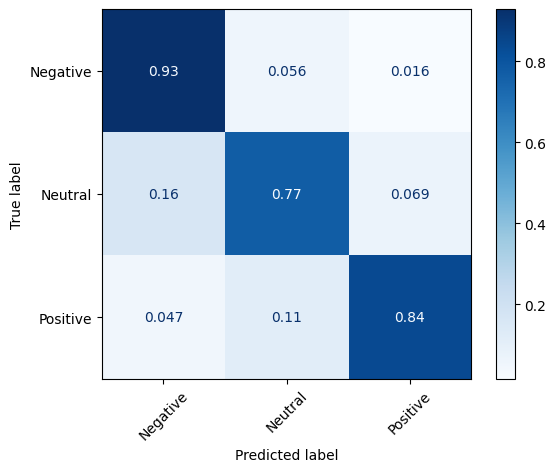

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(best_model, vect_test, y_test,normalize='true',cmap = 'Blues', xticks_rotation=45, display_labels=["Negative", "Neutral", "Positive"])

## Encoding the texts using the Base Sentence Transformer Model finetuned on SoftmaxLoss and running Classification Algorithms

In [ ]:
## Creating a function for transforming our dataset for finetuning the Sentence Transformers model on SoftmaxLoss
def input_example_generation(X_train, y_train, triplets, num_itr):
  train = pd.concat([X_train, y_train], axis=1)
  train_pos = train.loc[train["sentiment"] == 2]
  train_neg = train.loc[train["sentiment"] == 0]
  train_neu = train.loc[train["sentiment"] == 1]
  train_pos_text_list = train_pos["Text"].tolist()
  train_neg_text_list = train_neg["Text"].tolist()
  train_neu_text_list = train_neu["Text"].tolist()
  for x in range((num_itr)):
    for y in range(len(train_pos_text_list)):
      count = x*len(train_pos_text_list) + y
      # Setting the seed value to get the same set of random texts everytime
      random.seed(count)
      torch.manual_seed(count)
      # For each positive sentiment text, randomly selecting another positive text appending to triplet
      currentSentence = train_pos_text_list[y]
      posSentence = random.choice(train_pos_text_list)
      triplets.append(InputExample(texts=[currentSentence, posSentence], label=2))

  for x in range((num_itr)):
    for y in range(len(train_neu_text_list)):
      count = x*len(train_neu_text_list) + y
      # Setting the seed value to get the same set of random texts everytime
      random.seed(count)
      torch.manual_seed(count)
      # For each neutral sentiment text, randomly selecting another neutral text and appending to triplet
      currentSentence = train_neu_text_list[y]
      neuSentence = random.choice(train_neu_text_list)
      triplets.append(InputExample(texts=[currentSentence, neuSentence], label=1))

  for x in range((num_itr)):
    for y in range(len(train_neg_text_list)):
      count = x*len(train_neg_text_list) + y
      # Setting the seed value to get the same set of random texts everytime
      random.seed(count)
      torch.manual_seed(count)
      # For each negative sentiment text, randomly selecting another negative textand appending to triplet
      currentSentence = train_neg_text_list[y]
      negSentence = random.choice(train_neg_text_list)
      triplets.append(InputExample(texts=[currentSentence, negSentence], label=0))
  return (triplets)

In [ ]:
## Creating the Input Examples
train_examples = []
num_itr = 5
train_examples = input_example_generation((X_train), (y_train), train_examples,num_itr)
# Defining DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
# Specifying number of epochs and warmup steps
num_epochs = 1
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)

In [ ]:
# Defining Trainloss with loss as SoftmaxLoss
model = model_base
train_loss = losses.SoftmaxLoss(model,model.get_sentence_embedding_dimension(),num_labels=3)

In [ ]:
# Finetuning the model based on SoftmaxLoss
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3660 [00:00<?, ?it/s]

In [ ]:
# Encoding the X_train using base sentence transformer model
vect_train = model.encode(X_train_list, show_progress_bar = True)
vect_test = model.encode(X_test_list, show_progress_bar = True)

Batches:   0%|          | 0/366 [00:00<?, ?it/s]

Batches:   0%|          | 0/92 [00:00<?, ?it/s]

In [ ]:
# Running LGBoost algorithm for classification
# Defining values for the hyperparameters to search through
param_grid = {
'max_bin': [255, 765],
'num_iterations': [100, 150],
'num_leaves': [20, 31]
}
best_hyperparameters = {}
best_values = {}
# define the model
model_lgbm = LGBMClassifier(objective='multiclass', random_state=5)
# Initializing GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=model_lgbm, param_grid=param_grid,
                           scoring='accuracy', cv=5)
# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(vect_train, y_train)
# Getting the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())
print(best_hyperparameters)
print(best_values)
# Training the model with the best hyperparameters
best_model = LGBMClassifier(objective='multiclass',**best_params, random_state=5)
best_model.fit(vect_train, y_train)
# evaluate the model
y_pred = best_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 9369, number of used features: 1024
[LightGBM] [Info] Start training from score -0.466871
[LightGBM] [Info] Start training from score -1.552796
[LightGBM] [Info] Start training from score -1.823973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 9369, number of used features: 1024
[LightGBM] [Info] Start training from score -0.466871
[LightGBM] [Info] Start training from score -1.552796
[LightGBM] [Info] Start training from score -1.823973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.0604

In [ ]:
# Running XGBoost algorithm for classification
# Defining values for the hyperparameters to search through
param_grid = {
 'max_depth':range(4,10,2),
 'min_child_weight':range(1,6,2)
}
best_hyperparameters = {}
best_values = {}
# define the model
model_xgb = XGBClassifier(objective='multiclass', random_state=5)
# Initializing GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid,
                           scoring='accuracy', cv=5)
# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(vect_train, y_train)
# Getting the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())
print(best_hyperparameters)
print(best_values)
# Training the model with the best hyperparameters
best_model = XGBClassifier(objective='multiclass',**best_params, random_state=5)
best_model.fit(vect_train, y_train)
# evaluate the model
y_pred = best_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

['max_depth', 'min_child_weight']
[4, 1]
Confusion Matrix - 
 [[1723   94   18]
 [ 134  448   38]
 [  34   57  382]]
Classification report - 
               precision    recall  f1-score   support

           0     0.9112    0.9390    0.9249      1835
           1     0.7479    0.7226    0.7350       620
           2     0.8721    0.8076    0.8386       473

    accuracy                         0.8719      2928
   macro avg     0.8437    0.8231    0.8328      2928
weighted avg     0.8703    0.8719    0.8707      2928



## Encoding the texts using the Base Sentence Transformer Model finedtuned on CoSentLoss and running Classification Algorithms

In [ ]:
## Creating a function for transforming our dataset for finetuning the Sentence Transformers model on CoSentLoss
def input_example_generation(X_train, y_train, triplets, num_itr):
  train = pd.concat([X_train, y_train], axis=1)
  train_pos = train.loc[train["sentiment"] == 2]
  train_neg = train.loc[train["sentiment"] == 0]
  train_neu = train.loc[train["sentiment"] == 1]
  train_pos_text_list = train_pos["Text"].tolist()
  train_neg_text_list = train_neg["Text"].tolist()
  train_neu_text_list = train_neu["Text"].tolist()
  for x in range((num_itr)):
    for y in range(len(train_pos_text_list)):
      count = x*len(train_pos_text_list) + y
      # Setting the seed value to get the same set of random texts everytime
      random.seed(count)
      torch.manual_seed(count)
      # For each positive sentiment text, randomly selecting another positive text sentence and appending to triplet with target similarity score as 1.0
      currentSentence = train_pos_text_list[y]
      posSentence = random.choice(train_pos_text_list)
      triplets.append(InputExample(texts=[currentSentence, posSentence], label=1.0))
      # For each positive sentiment text, randomly selecting a negative sentiment text and appending to triplet with target similarity score as 0
      negSentence = random.choice(train_neg_text_list)
      triplets.append(InputExample(texts=[currentSentence, negSentence], label=-1.0))
      # For each positive sentiment text, randomly selecting a neutral sentiment text and appending to triplet with target similarity score as 0.5
      neuSentence = random.choice(train_neu_text_list)
      triplets.append(InputExample(texts=[currentSentence, neuSentence], label=0))
  return (triplets)

In [ ]:
## Creating the Input Examples
train_examples = []
num_itr = 5
train_examples = input_example_generation((X_train), (y_train), train_examples,num_itr)
# Defining DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
# Specifying number of epochs and warmup steps
num_epochs = 1
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)

In [ ]:
# Defining Trainloss with loss as CoSENTLoss
model = model_base
train_loss = losses.CoSENTLoss(model)

In [ ]:
# Finetuning the model based on CoSENTLoss
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1772 [00:00<?, ?it/s]

In [ ]:
# Encoding the X_train using base sentence transformer model
vect_train = model.encode(X_train_list, show_progress_bar = True)
vect_test = model.encode(X_test_list, show_progress_bar = True)

Batches:   0%|          | 0/366 [00:00<?, ?it/s]

Batches:   0%|          | 0/92 [00:00<?, ?it/s]

In [ ]:
# Running LGBoost algorithm for classification
# Defining values for the hyperparameters to search through
param_grid = {
'max_bin': [255, 765],
'num_iterations': [100, 150],
'num_leaves': [20, 31]
}
best_hyperparameters = {}
best_values = {}
# define the model
model_lgbm = LGBMClassifier(objective='multiclass', random_state=5)
# Initializing GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=model_lgbm, param_grid=param_grid,
                           scoring='accuracy', cv=5)
# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(vect_train, y_train)
# Getting the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())
print(best_hyperparameters)
print(best_values)
# Training the model with the best hyperparameters
best_model = LGBMClassifier(objective='multiclass',**best_params, random_state=5)
best_model.fit(vect_train, y_train)
# evaluate the model
y_pred = best_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 9369, number of used features: 1024
[LightGBM] [Info] Start training from score -0.466871
[LightGBM] [Info] Start training from score -1.552796
[LightGBM] [Info] Start training from score -1.823973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 9369, number of used features: 1024
[LightGBM] [Info] Start training from score -0.466871
[LightGBM] [Info] Start training from score -1.552796
[LightGBM] [Info] Start training from score -1.823973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.0403

In [ ]:
# Running XGBoost algorithm for classification
# Defining values for the hyperparameters to search through
param_grid = {
 'max_depth':range(4,10,2),
 'min_child_weight':range(1,6,2)
}
best_hyperparameters = {}
best_values = {}
# define the model
model_xgb = XGBClassifier(objective='multiclass', random_state=5)
# Initializing GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid,
                           scoring='accuracy', cv=5)
# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(vect_train, y_train)
# Getting the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())
print(best_hyperparameters)
print(best_values)
# Training the model with the best hyperparameters
best_model = XGBClassifier(objective='multiclass',**best_params, random_state=5)
best_model.fit(vect_train, y_train)
# evaluate the model
y_pred = best_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

['max_depth', 'min_child_weight']
[8, 1]
Confusion Matrix - 
 [[1719   93   23]
 [ 127  456   37]
 [  36   53  384]]
Classification report - 
               precision    recall  f1-score   support

           0     0.9134    0.9368    0.9249      1835
           1     0.7575    0.7355    0.7463       620
           2     0.8649    0.8118    0.8375       473

    accuracy                         0.8740      2928
   macro avg     0.8452    0.8280    0.8363      2928
weighted avg     0.8725    0.8740    0.8730      2928



## Encoding the texts using the Base Sentence Transformer Model finedtuned on BatchAllTripletLoss and running Classification Algorithms

In [ ]:
## Creating a function for transforming our dataset for finetuning the Sentence Transformers model on TripletLoss
def input_example_generation(X_train, y_train, triplets, num_itr):
  train = pd.concat([X_train, y_train], axis=1)
  train_pos = train.loc[train["sentiment"] == 2]
  train_neg = train.loc[train["sentiment"] == 0]
  train_neu = train.loc[train["sentiment"] == 1]
  train_pos_text_list = train_pos["Text"].tolist()
  train_neg_text_list = train_neg["Text"].tolist()
  train_neu_text_list = train_neu["Text"].tolist()
  for x in range((num_itr)):
    for y in range(len(train_pos_text_list)):
      count = x*len(train_pos_text_list) + y
      # Setting the seed value to get the same set of random texts everytime
      random.seed(count)
      torch.manual_seed(count)
      anchor = train_pos_text_list[y]
      triplets.append(InputExample(texts=[anchor], label=2))
      # For each anchor text, randomly selecting another text from the same class as the anchor and appending to triplet
      posSentence = random.choice(train_pos_text_list)
      triplets.append(InputExample(texts=[posSentence], label=2))
      # For each anchor text, randomly selecting another text from a different class(neutral sentiment class) as of the anchor and appending to triplet
      negSentence1 = random.choice(train_neu_text_list)
      triplets.append(InputExample(texts=[negSentence1], label=1))
      # For each anchor text, randomly selecting another text from a different class(negative sentiment class) as of the anchor and appending to triplet
      negSentence2 = random.choice(train_neg_text_list)
      triplets.append(InputExample(texts=[negSentence2], label=0))
  return (triplets)

In [ ]:
## Creating the Input Examples
train_examples = []
num_itr = 5
train_examples = input_example_generation((X_train), (y_train), train_examples,num_itr)
# Defining DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
# Specifying number of epochs and warmup steps
num_epochs = 1
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)

In [ ]:
# Defining Trainloss with loss as BatchAllTripletLoss
model = model_base
train_loss = losses.BatchAllTripletLoss(model)

In [ ]:
# Finetuning the model based on BatchAllTripletLoss
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2363 [00:00<?, ?it/s]

In [ ]:
# Encoding train and test data using finetuned model
vect_train = model.encode(X_train_list, show_progress_bar = True)
vect_test = model.encode(X_test_list, show_progress_bar = True)

Batches:   0%|          | 0/366 [00:00<?, ?it/s]

Batches:   0%|          | 0/92 [00:00<?, ?it/s]

In [ ]:
# Running LGBoost algorithm for classification
# Defining values for the hyperparameters to search through
param_grid = {
'max_bin': [255, 765],
'num_iterations': [100, 150],
'num_leaves': [20, 31]
}
best_hyperparameters = {}
best_values = {}
# define the model
model_lgbm = LGBMClassifier(objective='multiclass', random_state=5)
# Initializing GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=model_lgbm, param_grid=param_grid,
                           scoring='accuracy', cv=5)
# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(vect_train, y_train)
# Getting the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())
print(best_hyperparameters)
print(best_values)
# Training the model with the best hyperparameters
best_model = LGBMClassifier(objective='multiclass',**best_params, random_state=5)
best_model.fit(vect_train, y_train)
# evaluate the model
y_pred = best_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 9369, number of used features: 1024
[LightGBM] [Info] Start training from score -0.466871
[LightGBM] [Info] Start training from score -1.552796
[LightGBM] [Info] Start training from score -1.823973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 9369, number of used features: 1024
[LightGBM] [Info] Start training from score -0.466871
[LightGBM] [Info] Start training from score -1.552796
[LightGBM] [Info] Start training from score -1.823973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info]

In [ ]:
# Running XGBoost algorithm for classification
# Defining values for the hyperparameters to search through
param_grid = {
 'max_depth':range(4,10,2),
 'min_child_weight':range(1,6,2)
}
best_hyperparameters = {}
best_values = {}
# define the model
model_xgb = XGBClassifier(objective='multiclass', random_state=5)
# Initializing GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid,
                           scoring='accuracy', cv=5)
# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(vect_train, y_train)
# Getting the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())
print(best_hyperparameters)
print(best_values)
# Training the model with the best hyperparameters
best_model = XGBClassifier(objective='multiclass',**best_params, random_state=5)
best_model.fit(vect_train, y_train)
# evaluate the model
y_pred = best_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

['max_depth', 'min_child_weight']
[4, 3]
Confusion Matrix - 
 [[1741   75   19]
 [ 154  432   34]
 [  42   65  366]]
Classification report - 
               precision    recall  f1-score   support

           0     0.8988    0.9488    0.9231      1835
           1     0.7552    0.6968    0.7248       620
           2     0.8735    0.7738    0.8206       473

    accuracy                         0.8671      2928
   macro avg     0.8425    0.8064    0.8229      2928
weighted avg     0.8643    0.8671    0.8646      2928



## Encoding the texts using the Base Sentence Transformer Model finetuned on BatchHardSoftMarginTripletLoss and running Classification Algorithms

In [ ]:
# Defining Trainloss with loss as BatchHardSoftMarginTripletLoss
model = model_base
train_loss = losses.BatchHardSoftMarginTripletLoss(model)

In [ ]:
# Finetuning the model based on BatchHardSoftMarginTripletLoss
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2363 [00:00<?, ?it/s]

In [ ]:
# Encoding the X_train using base sentence transformer model
vect_train = model.encode(X_train_list, show_progress_bar = True)
vect_test = model.encode(X_test_list, show_progress_bar = True)

Batches:   0%|          | 0/366 [00:00<?, ?it/s]

Batches:   0%|          | 0/92 [00:00<?, ?it/s]

In [ ]:
# Running LGBoost algorithm for classification
# Defining values for the hyperparameters to search through
param_grid = {
'max_bin': [255, 765],
'num_iterations': [100, 150],
'num_leaves': [20, 31]
}
best_hyperparameters = {}
best_values = {}
# define the model
model_lgbm = LGBMClassifier(objective='multiclass', random_state=5)
# Initializing GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=model_lgbm, param_grid=param_grid,
                           scoring='accuracy', cv=5)
# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(vect_train, y_train)
# Getting the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())
print(best_hyperparameters)
print(best_values)
# Training the model with the best hyperparameters
best_model = LGBMClassifier(objective='multiclass',**best_params, random_state=5)
best_model.fit(vect_train, y_train)
# evaluate the model
y_pred = best_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 9369, number of used features: 1024
[LightGBM] [Info] Start training from score -0.466871
[LightGBM] [Info] Start training from score -1.552796
[LightGBM] [Info] Start training from score -1.823973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 9369, number of used features: 1024
[LightGBM] [Info] Start training from score -0.466871
[LightGBM] [Info] Start training from score -1.552796
[LightGBM] [Info] Start training from score -1.823973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.0511

In [ ]:
# Running XGBoost algorithm for classification
# Defining values for the hyperparameters to search through
param_grid = {
 'max_depth':range(4,10,2),
 'min_child_weight':range(1,6,2)
}
best_hyperparameters = {}
best_values = {}
# define the model
model_xgb = XGBClassifier(objective='multiclass', random_state=5)
# Initializing GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid,
                           scoring='accuracy', cv=5)
# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(vect_train, y_train)
# Getting the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())
print(best_hyperparameters)
print(best_values)
# Training the model with the best hyperparameters
best_model = XGBClassifier(objective='multiclass',**best_params, random_state=5)
best_model.fit(vect_train, y_train)
# evaluate the model
y_pred = best_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

['max_depth', 'min_child_weight']
[4, 1]
Confusion Matrix - 
 [[1732   85   18]
 [ 138  448   34]
 [  41   55  377]]
Classification report - 
               precision    recall  f1-score   support

           0     0.9063    0.9439    0.9247      1835
           1     0.7619    0.7226    0.7417       620
           2     0.8788    0.7970    0.8359       473

    accuracy                         0.8733      2928
   macro avg     0.8490    0.8212    0.8341      2928
weighted avg     0.8713    0.8733    0.8716      2928



## Encoding the texts using the Base Sentence Transformer Model finetuned on BatchHardTripletLoss and running Classification Algorithms

In [ ]:
# Defining Trainloss with loss as BatchHardTripletLoss
model = model_base
train_loss = losses.BatchHardTripletLoss(model)

In [ ]:
# Finetuning the model based on BatchHardTripletLoss
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2363 [00:00<?, ?it/s]

In [ ]:
# Encoding the X_train using base sentence transformer model
vect_train = model.encode(X_train_list, show_progress_bar = True)
vect_test = model.encode(X_test_list, show_progress_bar = True)

Batches:   0%|          | 0/366 [00:00<?, ?it/s]

Batches:   0%|          | 0/92 [00:00<?, ?it/s]

In [ ]:
# Running LGBoost algorithm for classification
# Defining values for the hyperparameters to search through
param_grid = {
'max_bin': [255, 765],
'num_iterations': [100, 150],
'num_leaves': [20, 31]
}
best_hyperparameters = {}
best_values = {}
# define the model
model_lgbm = LGBMClassifier(objective='multiclass', random_state=5)
# Initializing GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=model_lgbm, param_grid=param_grid,
                           scoring='accuracy', cv=5)
# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(vect_train, y_train)
# Getting the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())
print(best_hyperparameters)
print(best_values)
# Training the model with the best hyperparameters
best_model = LGBMClassifier(objective='multiclass',**best_params, random_state=5)
best_model.fit(vect_train, y_train)
# evaluate the model
y_pred = best_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 9369, number of used features: 1024
[LightGBM] [Info] Start training from score -0.466871
[LightGBM] [Info] Start training from score -1.552796
[LightGBM] [Info] Start training from score -1.823973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 9369, number of used features: 1024
[LightGBM] [Info] Start training from score -0.466871
[LightGBM] [Info] Start training from score -1.552796
[LightGBM] [Info] Start training from score -1.823973
[LightGBM] [Warni

In [ ]:
# Running XGBoost algorithm for classification
# Defining values for the hyperparameters to search through
param_grid = {
 'max_depth':range(4,10,2),
 'min_child_weight':range(1,6,2)
}
best_hyperparameters = {}
best_values = {}
# define the model
model_xgb = XGBClassifier(objective='multiclass', random_state=5)
# Initializing GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid,
                           scoring='accuracy', cv=5)
# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(vect_train, y_train)
# Getting the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())
print(best_hyperparameters)
print(best_values)
# Training the model with the best hyperparameters
best_model = XGBClassifier(objective='multiclass',**best_params, random_state=5)
best_model.fit(vect_train, y_train)
# evaluate the model
y_pred = best_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

['max_depth', 'min_child_weight']
[6, 3]
Confusion Matrix - 
 [[1722   92   21]
 [ 151  433   36]
 [  41   56  376]]
Classification report - 
               precision    recall  f1-score   support

           0     0.8997    0.9384    0.9186      1835
           1     0.7453    0.6984    0.7211       620
           2     0.8684    0.7949    0.8300       473

    accuracy                         0.8644      2928
   macro avg     0.8378    0.8106    0.8232      2928
weighted avg     0.8619    0.8644    0.8625      2928



## Encoding the texts using the Base Sentence Transformer Model finetuned on BatchSemiHardTripletLoss and running Classification Algorithms

In [ ]:
# Defining Trainloss with loss as BatchSemiHardTripletLoss
model = model_base
train_loss = losses.BatchSemiHardTripletLoss(model)

In [ ]:
# Finetuning the model based on BatchSemiHardTripletLoss
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2363 [00:00<?, ?it/s]

In [ ]:
# Encoding the X_train using base sentence transformer model
vect_train = model.encode(X_train_list, show_progress_bar = True)
vect_test = model.encode(X_test_list, show_progress_bar = True)

Batches:   0%|          | 0/366 [00:00<?, ?it/s]

Batches:   0%|          | 0/92 [00:00<?, ?it/s]

In [ ]:
# Running LGBoost algorithm for classification
# Defining values for the hyperparameters to search through
param_grid = {
'max_bin': [255, 765],
'num_iterations': [100, 150],
'num_leaves': [20, 31]
}
best_hyperparameters = {}
best_values = {}
# define the model
model_lgbm = LGBMClassifier(objective='multiclass', random_state=5)
# Initializing GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=model_lgbm, param_grid=param_grid,
                           scoring='accuracy', cv=5)
# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(vect_train, y_train)
# Getting the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())
print(best_hyperparameters)
print(best_values)
# Training the model with the best hyperparameters
best_model = LGBMClassifier(objective='multiclass',**best_params, random_state=5)
best_model.fit(vect_train, y_train)
# evaluate the model
y_pred = best_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 9369, number of used features: 1024
[LightGBM] [Info] Start training from score -0.466871
[LightGBM] [Info] Start training from score -1.552796
[LightGBM] [Info] Start training from score -1.823973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 9369, number of used features: 1024
[LightGBM] [Info] Start training from score -0.466871
[LightGBM] [Info] Start training from score -1.552796
[LightGBM] [Info] Start training from score -1.823973
[LightGBM] [Warni

In [ ]:
# Running XGBoost algorithm for classification
# Defining values for the hyperparameters to search through
param_grid = {
 'max_depth':range(4,10,2),
 'min_child_weight':range(1,6,2)
}
best_hyperparameters = {}
best_values = {}
# define the model
model_xgb = XGBClassifier(objective='multiclass', random_state=5)
# Initializing GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid,
                           scoring='accuracy', cv=5)
# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(vect_train, y_train)
# Getting the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())
print(best_hyperparameters)
print(best_values)
# Training the model with the best hyperparameters
best_model = XGBClassifier(objective='multiclass',**best_params, random_state=5)
best_model.fit(vect_train, y_train)
# evaluate the model
y_pred = best_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

['max_depth', 'min_child_weight']
[4, 1]
Confusion Matrix - 
 [[1724   88   23]
 [ 152  427   41]
 [  51   48  374]]
Classification report - 
               precision    recall  f1-score   support

           0     0.8947    0.9395    0.9165      1835
           1     0.7584    0.6887    0.7219       620
           2     0.8539    0.7907    0.8211       473

    accuracy                         0.8624      2928
   macro avg     0.8357    0.8063    0.8198      2928
weighted avg     0.8592    0.8624    0.8599      2928

